# Imports, Helper Functions, and Loading

In [15]:

import numpy as np
import matplotlib.pyplot as plt
#import functools
# import operator
import pandas as pd

import healpy as hp

import lsst.daf.butler as dafButler
from lsst.analysis.ap import apdb
from lsst.daf.butler import DataCoordinate
from lsst.obs.lsst import RubinDimensionPacker

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

plt.set_loglevel('WARNING')

In [2]:
## Grouping tracts based on location on the sky
group1 = [3384, 3385]
group2 = [2261, 2262, 2494, 2495]
group3 = [9880, 9881, 9638]
group4 = [3533, 3534, 3345, 3346]
group5 = [7683, 7684, 7445, 7446]
group6 = [9590, 9591, 9347, 9348]
group7 = [9812, 9813]
group8 = [7149, 6914, 6915]

groups = [group1, group2, group3, group4, group5, group6, group7, group8]

In [3]:
def getUniqueVisits(collections, tracts):
    """Get the unique visits from a given tract."""
    visitList = []
    tracts = ','.join(str(tract) for tract in tracts)
    for d in sorted(registry.queryDatasets(datasetType="goodSeeingDiff_diaSrcTable", collections=collections, where=f"skymap='ops_rehersal_prep_2k_v1' AND tract IN ({tracts})")): 
        visitList.append(d.dataId['visit'])
    uniqueVisits = list(set(visitList))
    return uniqueVisits

## Loading Data


In [4]:
repo = '/repo/embargo'
instrument = 'LSSTComCamSim'
collections = 'u/elhoward/DM-43098/LSSTComCamSim'
schema = f'elhoward_dm43098_lsstcomcamsim_appipe'

butler = dafButler.Butler(repo, instrument=instrument)
registry = butler.registry
skymap = butler.get("skyMap", collections=collections, skymap="ops_rehersal_prep_2k_v1")
apdbQuery = apdb.ApdbPostgresQuery(butler=butler, instrument=instrument, namespace=schema)

INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/n/ncaplar/.lsst/aws-credentials.ini


In [5]:
visitListByGroup = []

for group in groups:
    visits = getUniqueVisits(collections, group)
    visitListByGroup.append(visits)
    print("There are "+str(len(visits))+f" visits in tracts {group}")

There are 119 visits in tracts [3384, 3385]
There are 352 visits in tracts [2261, 2262, 2494, 2495]
There are 298 visits in tracts [9880, 9881, 9638]
There are 295 visits in tracts [3533, 3534, 3345, 3346]
There are 354 visits in tracts [7683, 7684, 7445, 7446]
There are 238 visits in tracts [9590, 9591, 9347, 9348]
There are 356 visits in tracts [9812, 9813]
There are 299 visits in tracts [7149, 6914, 6915]


In [6]:
# nImage1 = butler.get('goodSeeingCoadd_nImage', tract=9880, collections = collections,  band='r', patch = 100, skymap='ops_rehersal_prep_2k_v1')

In [7]:
# let us look at one tract, just randomly 3533
tract_id = 3533

tractInfo = skymap.generateTract(tract_id)
tractInfo_vertices = tractInfo.vertex_list

In [8]:
vertices_as_deg = []
for i in range(0,4):
   vertices_as_deg.append([tractInfo_vertices[i].getRa().asDegrees(), tractInfo_vertices[i].getDec().asDegrees()])
vertices_as_deg = np.array(vertices_as_deg)

ra_min = np.min(vertices_as_deg[:,0])
ra_max = np.max(vertices_as_deg[:,0])
dec_min = np.min(vertices_as_deg[:,1])
dec_max = np.max(vertices_as_deg[:,1])

In [9]:
# This is to see all of the columns avaliable
with apdbQuery.connection as connection:
    # Query to fetch all column names from the DiaObject table
    query_columns = '''
    SELECT column_name
    FROM information_schema.columns
    WHERE table_schema = 'elhoward_dm43098_lsstcomcamsim_appipe' AND table_name = 'DiaSource';
    '''
    df_columns = pd.read_sql_query(query_columns, connection)
    print("Available columns:", df_columns['column_name'].tolist())

Available columns: ['diaSourceId', 'ccdVisitId', 'diaObjectId', 'ssObjectId', 'parentDiaSourceId', 'ssObjectReassocTime', 'midpointMjdTai', 'ra', 'raErr', 'dec', 'decErr', 'ra_dec_Cov', 'x', 'xErr', 'y', 'yErr', 'x_y_Cov', 'apFlux', 'apFluxErr', 'snr', 'psfFlux', 'psfFluxErr', 'psfRa', 'psfRaErr', 'psfDec', 'psfDecErr', 'psfFlux_psfRa_Cov', 'psfFlux_psfDec_Cov', 'psfRa_psfDec_Cov', 'psfLnL', 'psfChi2', 'psfNdata', 'trailFlux', 'trailFluxErr', 'trailRa', 'trailRaErr', 'trailDec', 'trailDecErr', 'trailLength', 'trailLengthErr', 'trailAngle', 'trailAngleErr', 'trailFlux_trailRa_Cov', 'trailFlux_trailDec_Cov', 'trailFlux_trailLength_Cov', 'trailFlux_trailAngle_Cov', 'trailRa_trailDec_Cov', 'trailRa_trailLength_Cov', 'trailRa_trailAngle_Cov', 'trailDec_trailLength_Cov', 'trailDec_trailAngle_Cov', 'trailLength_trailAngle_Cov', 'trailLnL', 'trailChi2', 'trailNdata', 'dipoleMeanFlux', 'dipoleMeanFluxErr', 'dipoleFluxDiff', 'dipoleFluxDiffErr', 'dipoleRa', 'dipoleRaErr', 'dipoleDec', 'dipoleDec

In [10]:
# this snipet allows you to translate between (ccd, visit) and ccdVisitId
packer = RubinDimensionPacker(DataCoordinate.standardize({"instrument": 'LATISS'}, universe=butler.dimensions), config=RubinDimensionPacker.ConfigClass(), is_exposure=False)
packer.pack({"instrument": 'LATISS', "detector": 0, "visit": 7024040200361})
dataId = DataCoordinate.standardize({"instrument": 'LATISS', "detector": 0, "visit": 7024040200361}, universe=butler.dimensions)
print(dataId)
ccdVisitId = packer.pack(dataId)
packer.unpack(ccdVisitId)

{instrument: 'LATISS', detector: 0, visit: 7024040200361}


{instrument: 'LATISS', detector: 0, visit: 7024040200361}

In [12]:
# let us say that we want to get all diaSources and diaObjects from this one tract
with apdbQuery.connection as connection:
    pp_source_table = pd.read_sql_query(f'SELECT "diaSourceId", "diaObjectId", "ra", "dec", "midpointMjdTai", \
        "ccdVisitId", \
        "psfFlux", "psfFluxErr", \
        "scienceFlux", "scienceFluxErr", "snr", \
        "flags", "band", "time_processed", "time_withdrawn"  \
        FROM "{schema}"."DiaSource" \
        WHERE "ra" BETWEEN {ra_min} AND {ra_max} \
        AND "dec" BETWEEN {dec_min} AND {dec_max} \
        LIMIT 3000000; ''', connection)
  

with apdbQuery.connection as connection:
    pp_object_table = pd.read_sql_query(f'''SELECT "diaObjectId", "ra", "dec", "flags", "nDiaSources", \
        "validityStart", "validityEnd", "lastNonForcedSource"
        FROM "{schema}"."DiaObject"
        WHERE "ra" BETWEEN {ra_min} AND {ra_max}
        AND "dec" BETWEEN {dec_min} AND {dec_max}
        AND "validityEnd" IS NULL
        LIMIT 2000000;
        ''', connection)
    
# assert that you got all of them, i.e., that the length of the outpus is lower than the limit requested
assert (len(pp_source_table)) < 3000000
assert (len(pp_object_table)) < 2000000

In [17]:
# let us say we want to look at the detector 2 during visit 7024040300256

dataId = DataCoordinate.standardize({"instrument": 'LATISS', "detector": 2, "visit": 7024040300256}, universe=butler.dimensions)
ccdVisitId = packer.pack(dataId)

src_single_visit_det = pp_source_table[pp_source_table['ccdVisitId']==ccdVisitId]
# just to confirm we are getting what we want
print(packer.unpack(ccdVisitId))
# let us store time of the observation for the future
midpointMjdTai = src_single_visit_det['midpointMjdTai'].values[0]
src_single_visit_det

{instrument: 'LATISS', detector: 2, visit: 7024040300256}


,diaSourceId,diaObjectId,ra,dec,midpointMjdTai,ccdVisitId,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr,snr,flags,band,time_processed,time_withdrawn
20219,3065473877497872440,3065473877497872440,224.525193,-39.639212,60404.126433,730865926146,3258.519877,620.074888,262390.114025,608.817151,5.370881,8388608,i,2024-04-21 01:28:55.958063,None
20220,3065473877497872441,3065473877497872441,224.521171,-39.678085,60404.126433,730865926146,-3432.358386,407.379717,7467.589210,397.998721,8.462321,9605120,i,2024-04-21 01:28:55.958063,None
20221,3065473877497872386,3065473877497872386,224.505329,-39.641970,60404.126433,730865926146,2162.317403,406.179898,10555.611117,397.591311,5.266704,14319616,i,2024-04-21 01:28:55.958063,None
20222,3065473877497872389,3065473877497872389,224.493197,-39.766515,60404.126433,730865926146,3361.067656,586.634446,177133.461720,577.815220,5.604084,0,i,2024-04-21 01:28:55.958063,None
20223,3065473877497872390,3065473877497872390,224.511912,-39.597511,60404.126433,730865926146,3996.160469,409.207901,10989.235125,401.402493,9.663493,0,i,2024-04-21 01:28:55.958063,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20814,3065473877497873212,3065473877497873212,224.790139,-39.660608,60404.126433,730865926146,4130.761585,649.912636,273895.217350,641.142103,6.067639,0,i,2024-04-21 01:28:55.958063,None
20815,3065473877497873213,3065473877497873213,224.797034,-39.599655,60404.126433,730865926146,9163.254709,418.963647,17842.156617,415.850911,21.739445,9605120,i,2024-04-21 01:28:55.958063,None
20816,3065473877497873214,3065473877497873214,224.784525,-39.704591,60404.126433,730865926146,2033.548077,406.053691,12636.030202,400.270945,5.263713,9601024,i,2024-04-21 01:28:55.958063,None
20817,3065473877497873215,3065473877497873215,224.787439,-39.684022,60404.126433,730865926146,-2362.344956,400.258752,2046.339082,394.221112,6.532410,9605120,i,2024-04-21 01:28:55.958063,None


In [35]:
# this is to figure out which healpy corresponds to the observations

# figure out the center of the observations
ra_cent = np.median(src_single_visit_det['ra'])
dec_cent = np.median(src_single_visit_det['dec'])
vec = hp.ang2vec(np.deg2rad((np.abs(dec_cent) + 90)), np.deg2rad(ra_cent))
# from this you can get closet healpixels
ipix_disc = hp.query_disc(nside=32, vec=vec, radius=np.radians(1) )
# take the first value if there are more pixels found nearby 
healpix_id = ipix_disc[0]

# path to the truth catalogs
path_to_tru_cat = '/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-3/imSim_catalogs/skyCatalogs/'

# loads stars, galaxies, solar system objects
df_single_ps = pd.read_parquet(path_to_tru_cat+'pointsource_'+str(healpix_id)+'.parquet')
df_single_sso = pd.read_parquet(path_to_tru_cat+'sso_'+str(healpix_id)+'.parquet')
df_single_gal = pd.read_parquet(path_to_tru_cat+'galaxy_'+str(healpix_id)+'.parquet')
# for galaxies you have to add 360 to ra because it seems to be from -180 to 180
# and others are 0 to 360
if np.median(df_single_gal['ra']) < 0: 
    df_single_gal['ra'] = df_single_gal['ra'] + 360

# find variable objects (only stars are variable in this rehersal)
df_single_ps_var = df_single_ps[df_single_ps['is_variable']==True]
df_single_ps_no_var = df_single_ps[df_single_ps['is_variable']==False]

# let us find the max and min extent of the visit
ra_min = np.min(src_single_visit_det['ra'])
ra_max = np.max(src_single_visit_det['ra'])
dec_min = np.min(src_single_visit_det['dec'])
dec_max = np.max(src_single_visit_det['dec'])


# cut the simulated objectd to the area that overlaps
df_single_ps_var_zoom = df_single_ps_var[(df_single_ps_var['ra']<ra_max) & (df_single_ps_var['ra']>ra_min) &\
    (df_single_ps_var['dec']<dec_max) & (df_single_ps_var['dec']>dec_min) ]
df_single_ps_no_var_zoom = df_single_ps_no_var[(df_single_ps_no_var['ra']<ra_max) & (df_single_ps_no_var['ra']>ra_min) &\
    (df_single_ps_no_var['dec']<dec_max) & (df_single_ps_no_var['dec']>dec_min) ]
df_single_gal_zoom = df_single_gal[(df_single_gal['ra']<ra_max) & (df_single_gal['ra']>ra_min) &\
    (df_single_gal['dec']<dec_max) & (df_single_gal['dec']>dec_min) ]

# for solar system we need more work, to get their exact positions during the observations
# this is very ineficent code
sso_ids = np.unique(df_single_sso['id'])
list_of_sso_single_exp = []
for i in range(len(sso_ids)):
    # for object, find all positions, fit as a position of the time and return
    df_single_sso_single_id = df_single_sso[df_single_sso['id']==sso_ids[i]]
    ra_fit = np.polyfit(df_single_sso_single_id['mjd'],df_single_sso_single_id['ra'], deg = 2)
    dec_fit = np.polyfit(df_single_sso_single_id['mjd'],df_single_sso_single_id['dec'], deg = 2)
    ra_poly = np.poly1d(ra_fit)
    dec_poly = np.poly1d(dec_fit)

    # Predicting values
    predicted_ra = ra_poly(midpointMjdTai)
    predicted_dec = dec_poly(midpointMjdTai)
    list_of_sso_single_exp.append([sso_ids[i], predicted_ra, predicted_dec])
    
array_of_sso_single_exp = np.array(list_of_sso_single_exp)
df_single_sso = pd.DataFrame(array_of_sso_single_exp, columns=['id', 'ra', 'dec'])
df_single_sso['ra'] = df_single_sso['ra'].astype(float)
df_single_sso['dec'] = df_single_sso['dec'].astype(float)    
    
df_single_sso_zoom = df_single_sso[(df_single_sso['ra']<ra_max) & (df_single_sso['ra']>ra_min) &\
    (df_single_sso['dec']<dec_max) & (df_single_sso['dec']>dec_min) ]



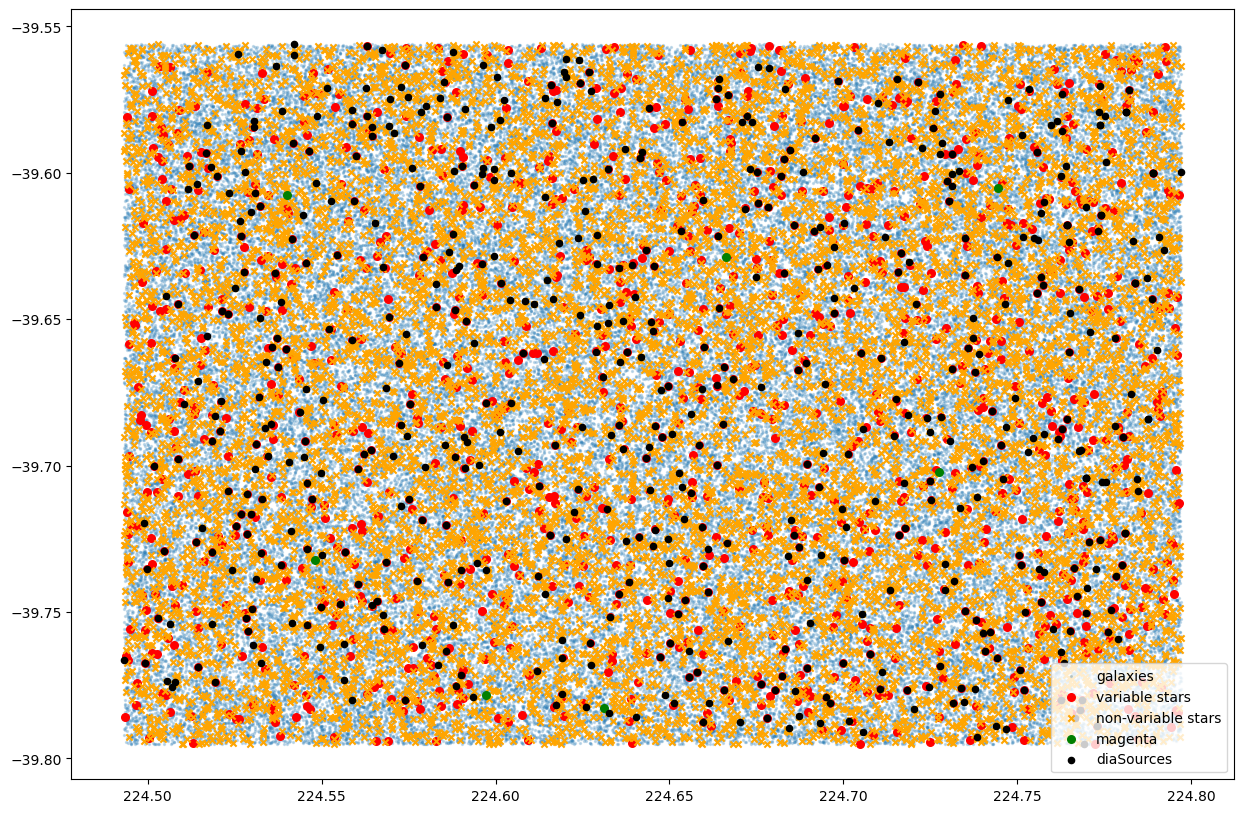

In [40]:
plt.figure(figsize=(15,10))

plt.scatter(df_single_gal_zoom['ra'], df_single_gal_zoom['dec'], s=2, alpha=0.21, label = 'galaxies')
plt.scatter(df_single_ps_var_zoom['ra'], df_single_ps_var_zoom['dec'], s=30, alpha=1, label = 'variable stars', color = 'red', marker='o')
plt.scatter(df_single_ps_no_var_zoom['ra'], df_single_ps_no_var_zoom['dec'], s=20, alpha=1, label = 'non-variable stars', color = 'orange', marker='x')
plt.scatter(df_single_sso_zoom['ra'], df_single_sso_zoom['dec'], s=30, alpha=1, label = 'magenta', color ='green')
plt.scatter(src_single_visit_det['ra'], src_single_visit_det['dec'], s=20, alpha=1, label = 'diaSources', color ='black')
plt.legend()

In [ ]:
# given diaSource give me everything in the true Table within 1 arcSec?
# call butler to show the image?